# EECS 498-007/598-005 Assignment 6: Generative Adversarial Networks 

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

# Generative Adversarial Networks (GANs)

So far in this course, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

![caption](https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a6/gan_outputs_pytorch.png)

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-e51kco3k
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-e51kco3k
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=fc39ba45217cd24ecbf93b4eb1d56ac11181b57564a7192fd1a431ad6b4e1a27
  Stored in directory: /tmp/pip-ephem-wheel-cache-v69wvlaa/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook.

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from coutils import fix_random_seed, rel_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for all operations.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [3]:
dtype = torch.float
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [4]:
def show_images(images):
  images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
  sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
  sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(sqrtn, sqrtn))
  gs = gridspec.GridSpec(sqrtn, sqrtn)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([sqrtimg,sqrtimg]))
  return 

def count_params(model):
  """Count the number of parameters in the model"""
  param_count = sum([p.numel() for p in model.parameters()])
  return param_count

answers = {}
answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)
answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)

## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [5]:
class Flatten(nn.Module):
  def forward(self, x):
    N, C, H, W = x.size() # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
  """
  An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
  to produce an output of shape (N, C, H, W).
  """
  def __init__(self, N=-1, C=128, H=7, W=7):
    super(Unflatten, self).__init__()
    self.N = N
    self.C = C
    self.H = H
    self.W = W
  def forward(self, x):
    return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    init.xavier_uniform_(m.weight.data)

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

download MNIST if not exist


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


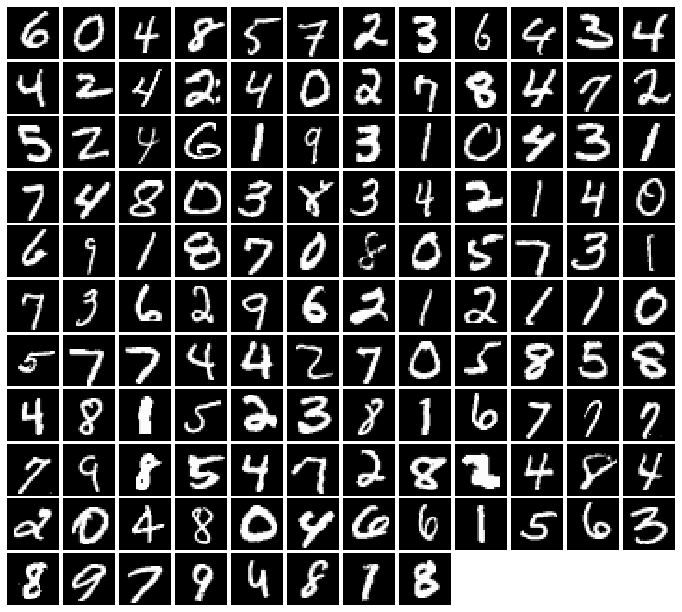

In [6]:
NOISE_DIM = 96
batch_size = 128

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784)
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [51]:
def sample_noise(batch_size, dim, dtype=torch.float, device='cpu'):
  """
  Generate a PyTorch Tensor of uniform random noise.

  Input:
  - batch_size: Integer giving the batch size of noise to generate.
  - dim: Integer giving the dimension of noise to generate.
  
  Output:
  - A PyTorch Tensor of shape (batch_size, dim) containing uniform
    random noise in the range (-1, 1).
  """
  ##############################################################################
  # TODO: Implement sample_noise.                                              #
  ##############################################################################
  # Replace "pass" statement with your code
  #tensor = (1 - (-1)) * torch.randn(batch_size,dim) + -1 
  tensor = torch.FloatTensor(batch_size,dim).uniform_(-1,1)
  tensor = tensor.to(device=device)
  return tensor
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################


Make sure noise is the correct shape and type:

In [47]:
fix_random_seed(0)

batch_size = 3
dim = 4

z = sample_noise(batch_size, dim)
assert z.shape == (batch_size, dim)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [42]:
def discriminator():
  """
  Build and return a PyTorch model implementing the architecture above.
  """
  model = nn.Sequential(
    ############################################################################
    # TODO: Implement discriminator.                                           #
    ############################################################################
    # Replace "pass" statement with your code
    Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.LeakyReLU(1e-2),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(1e-2),
    torch.nn.Linear(256,1)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
  )
  return model

Test to make sure the number of parameters in the discriminator is correct:

In [17]:
def test_discriminator(true_count=267009):
  model = discriminator()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in discriminator. Check your achitecture.')
  else:
    print('Correct number of parameters in discriminator.')     

test_discriminator()

267009
Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [19]:
def generator(noise_dim=NOISE_DIM):
  """
  Build and return a PyTorch model implementing the architecture above.
  """
  model = nn.Sequential(
    ############################################################################
    # TODO: Implement generator.                                               #
    ############################################################################
    # Replace "pass" statement with your code
    nn.Linear(noise_dim,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,784),
    nn.Tanh()
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
  )
  return model

Test to make sure the number of parameters in the generator is correct:

In [20]:
def test_generator(true_count=1858320):
  model = generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_generator()

1858320
Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above -- instead we will implement the sigmoid as part of the loss function.

**HINTS**: You can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy-with-logits) to compute these losses in a numerically stable manner. Since this function has a very long name, we've imported it for you under the name `bce_loss`.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

`true_labels = torch.ones(size, device=device)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [21]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

In [48]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.
  
  Inputs:
  - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None
  ##############################################################################
  # TODO: Implement discriminator_loss.                                        #
  ##############################################################################
  # Replace "pass" statement with your code
  loss = bce_loss(logits_real, torch.ones_like(logits_real,device=device)) + bce_loss(logits_fake,torch.zeros_like(logits_fake, device=device))
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################
  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing the (scalar) loss for the generator.
  """
  loss = None
  ##############################################################################
  # TODO: Implement generator_loss.                                            #
  ##############################################################################
  # Replace "pass" statement with your code
  loss = bce_loss(logits_fake, torch.ones_like(logits_fake,device=device))
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################
  return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [24]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
  d_loss = discriminator_loss(logits_real, logits_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [27]:
def test_generator_loss(logits_fake, g_loss_true):
  g_loss = generator_loss(logits_fake)
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 0


# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [39]:
def get_optimizer(model):
  """
  Construct and return an Adam optimizer for the model with learning rate 1e-3,
  beta1=0.5, and beta2=0.999.
  
  Input:
  - model: A PyTorch model that we want to optimize.
  
  Returns:
  - An Adam optimizer for the model with the desired hyperparameters.
  """
  optimizer = None
  ##############################################################################
  # TODO: Implement optimizer.                                                 #
  ##############################################################################
  # Replace "pass" statement with your code
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,betas=(0.5, 0.999))
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################
  return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [49]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
  """
  Train a GAN!
  
  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.to(device)
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1

Iter: 0, D: 1.37, G:0.6857


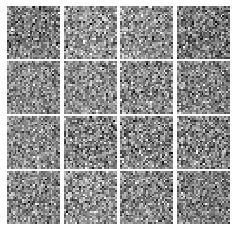


Iter: 250, D: 0.9688, G:1.068


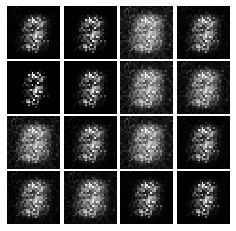


Iter: 500, D: 1.182, G:0.9094


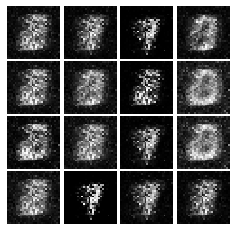


Iter: 750, D: 1.348, G:0.9055


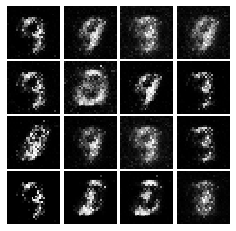


Iter: 1000, D: 1.105, G:1.68


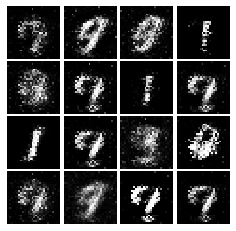


Iter: 1250, D: 1.46, G:1.237


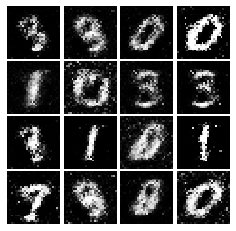


Iter: 1500, D: 1.211, G:1.45


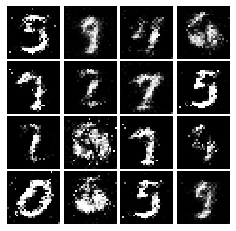


Iter: 1750, D: 1.347, G:1.05


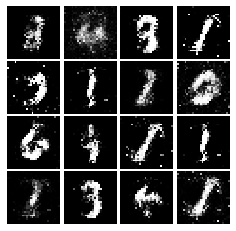


Iter: 2000, D: 1.306, G:0.9346


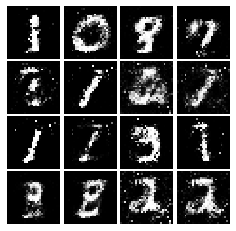


Iter: 2250, D: 1.248, G:0.9705


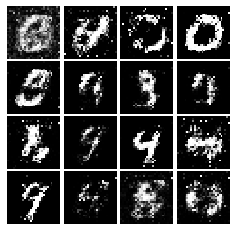


Iter: 2500, D: 1.28, G:0.8382


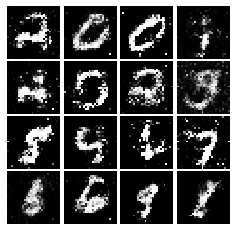


Iter: 2750, D: 1.289, G:0.7877


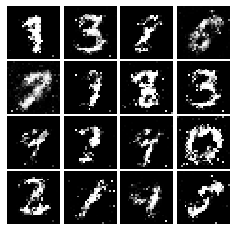


Iter: 3000, D: 1.3, G:0.8371


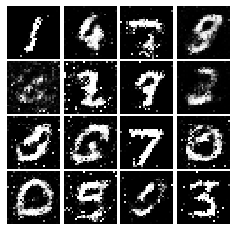


Iter: 3250, D: 1.335, G:0.8442


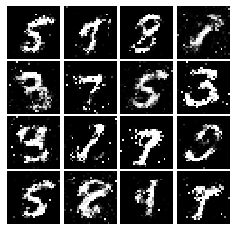


Iter: 3500, D: 1.34, G:0.8818


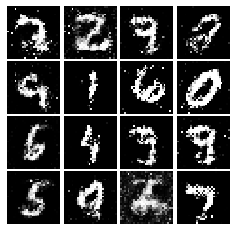


Iter: 3750, D: 1.393, G:0.8158


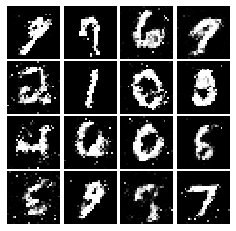


Iter: 4000, D: 1.345, G:0.8629


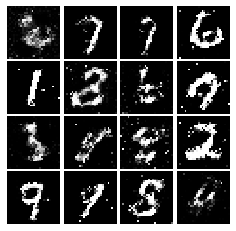


Iter: 4250, D: 1.314, G:0.7258


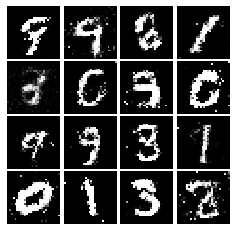


Iter: 4500, D: 1.327, G:0.7518


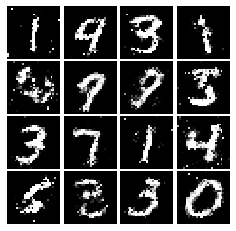

In [52]:
fix_random_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generator
G = generator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In these equations, we assume that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [57]:
def ls_discriminator_loss(scores_real, scores_fake):
  """
  Compute the Least-Squares GAN loss for the discriminator.
  
  Inputs:
  - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Outputs:
  - loss: A PyTorch Tensor containing the loss.
  """
  loss = None
  ##############################################################################
  # TODO: Implement ls_discriminator_loss.                                     #
  ##############################################################################
  # Replace "pass" statement with your code
  loss = 0.5 * (torch.mean((scores_real-torch.ones_like(scores_real,device=device))**2) + torch.mean(scores_fake**2))
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################
  return loss

def ls_generator_loss(scores_fake):
  """
  Computes the Least-Squares GAN loss for the generator.
  
  Inputs:
  - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Outputs:
  - loss: A PyTorch Tensor containing the loss.
  """
  loss = None
  ##############################################################################
  # TODO: Implement ls_generator_loss.                                         #
  ##############################################################################
  # Replace "pass" statement with your code
  loss = 0.5 * torch.mean((scores_fake - torch.ones_like(scores_fake,device=device))**2)
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################
  return loss

Before running a GAN with our new loss function, let's check it:

In [58]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
  d_loss = ls_discriminator_loss(score_real, score_fake)
  g_loss = ls_generator_loss(score_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Run the following cell to train your model!

Iter: 0, D: 0.4407, G:0.4583


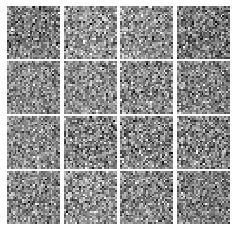


Iter: 250, D: 0.2277, G:0.04903


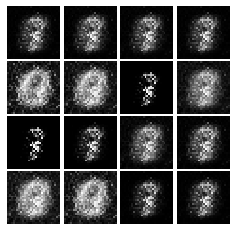


Iter: 500, D: 0.1799, G:0.2545


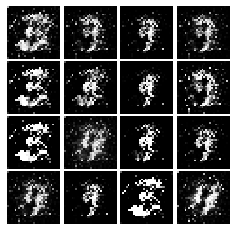


Iter: 750, D: 0.1255, G:0.3575


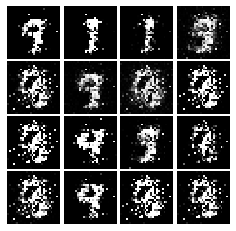


Iter: 1000, D: 0.1781, G:0.5033


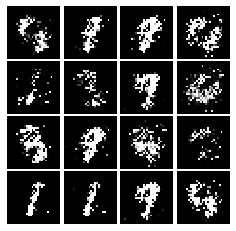


Iter: 1250, D: 0.1718, G:0.1929


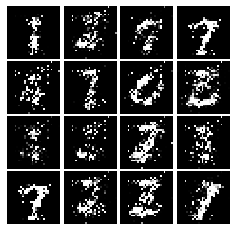


Iter: 1500, D: 0.3816, G:0.7645


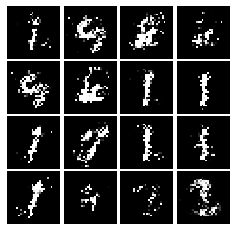


Iter: 1750, D: 0.1778, G:0.2125


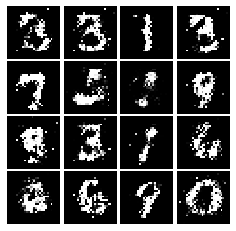


Iter: 2000, D: 0.2209, G:0.222


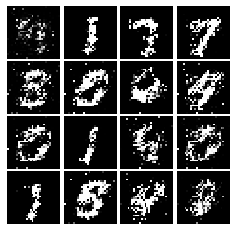


Iter: 2250, D: 0.222, G:0.1517


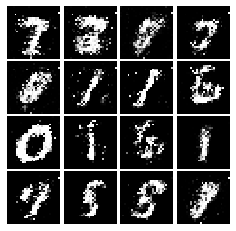


Iter: 2500, D: 0.2482, G:0.1732


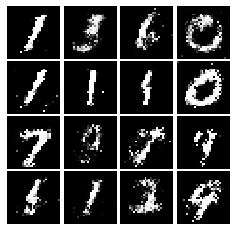


Iter: 2750, D: 0.2338, G:0.1604


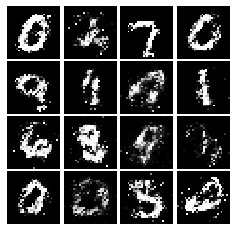


Iter: 3000, D: 0.2324, G:0.1681


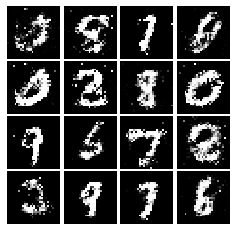


Iter: 3250, D: 0.2418, G:0.166


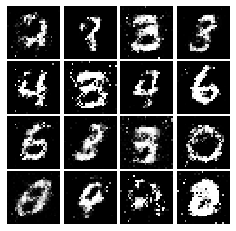


Iter: 3500, D: 0.2436, G:0.1468


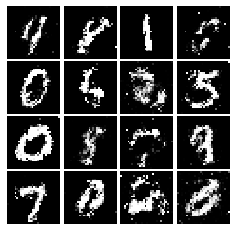


Iter: 3750, D: 0.2178, G:0.1544


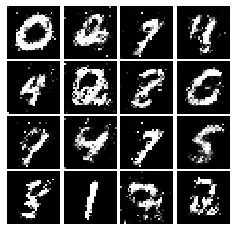


Iter: 4000, D: 0.2382, G:0.1902


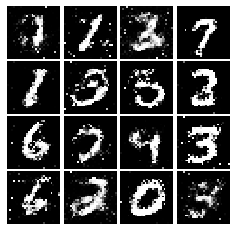


Iter: 4250, D: 0.2293, G:0.1751


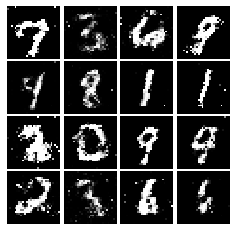


Iter: 4500, D: 0.224, G:0.1662


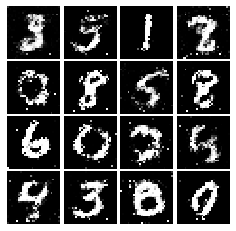

In [59]:
fix_random_seed(0)

D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [62]:
def build_dc_classifier():
  """
  Build and return a PyTorch model for the DCGAN discriminator implementing
  the architecture above.
  """
  return nn.Sequential(
    ############################################################################
    # TODO: Implement build_dc_classifier.                                     #
    ############################################################################
    # Replace "pass" statement with your code
    Unflatten(-1,1,28,28),
    nn.Conv2d(1,32,(5,5),stride=1),
    nn.LeakyReLU(1e-2),
    nn.MaxPool2d((2,2),stride=2),
    nn.Conv2d(32,64,(5,5),stride=1),
    nn.LeakyReLU(1e-2),
    nn.MaxPool2d(2,stride=2),
    Flatten(),
    nn.Linear(1024,1024),
    nn.LeakyReLU(1e-2),
    nn.Linear(1024,1)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
  )

data = next(enumerate(loader_train))[-1][0].to(dtype=dtype, device=device)
batch_size = data.size(0)
b = build_dc_classifier().to(device)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [63]:
def test_dc_classifer(true_count=1102721):
  model = build_dc_classifier()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_classifer()

1102721
Correct number of parameters in generator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/nn.html#convtranspose2d). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [86]:
def build_dc_generator(noise_dim=NOISE_DIM):
  """
  Build and return a PyTorch model implementing the DCGAN generator using
  the architecture described above.
  """
  return nn.Sequential(
    ############################################################################
    # TODO: Implement build_dc_generator.                                      #
    ############################################################################
    # Replace "pass" statement with your code
    nn.Linear(noise_dim,1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024,6272),
    nn.ReLU(),
    nn.BatchNorm1d(6272),
    Unflatten(-1, 128, 7, 7),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
    nn.Tanh(),
    Flatten()
    #for `tf.layers.conv2d_transpose()` with given padding:
    #out_height = strides[1] * (in_height - 1) + kernel_size[0] - 2 * padding_height
    #out_width  = strides[2] * (in_width - 1) + kernel_size[1] - 2 * padding_width'''
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
  )

test_g_gan = build_dc_generator().to(device)
#print(test_g_gan)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, dtype=dtype, device=device)
#print(batch_size)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [87]:
def test_dc_generator(true_count=6580801):
  model = build_dc_generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_generator()

6580801
Correct number of parameters in generator.


Iter: 0, D: 1.394, G:0.8042


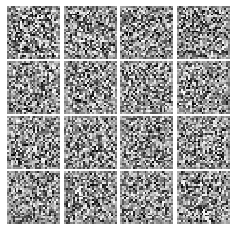


Iter: 250, D: 1.111, G:0.8039


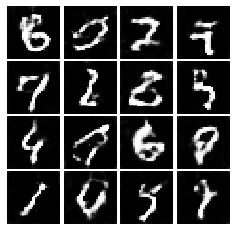


Iter: 500, D: 1.141, G:0.9009


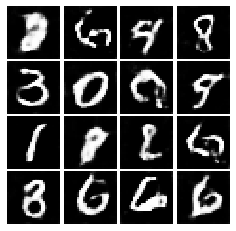


Iter: 750, D: 1.116, G:0.9657


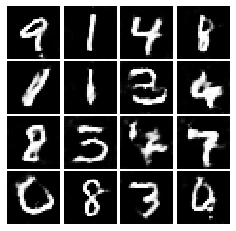


Iter: 1000, D: 1.153, G:1.051


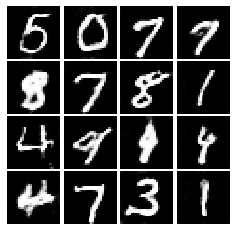


Iter: 1250, D: 1.238, G:0.9055


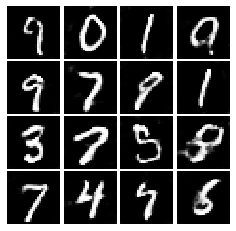


Iter: 1500, D: 1.062, G:0.9727


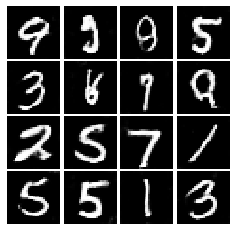


Iter: 1750, D: 1.174, G:0.566


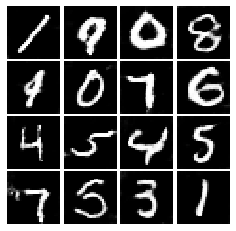


Iter: 2000, D: 1.148, G:0.7579


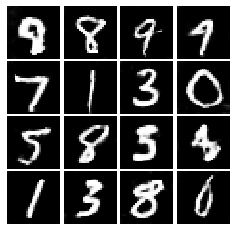


Iter: 2250, D: 1.083, G:1.332


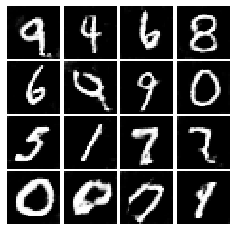

In [88]:
fix_random_seed(0)

D_DC = build_dc_classifier().to(device) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().to(device)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

#### Latent Space Interpolation
As a final test of our trained GAN model, we can perform interpolation in latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interplate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

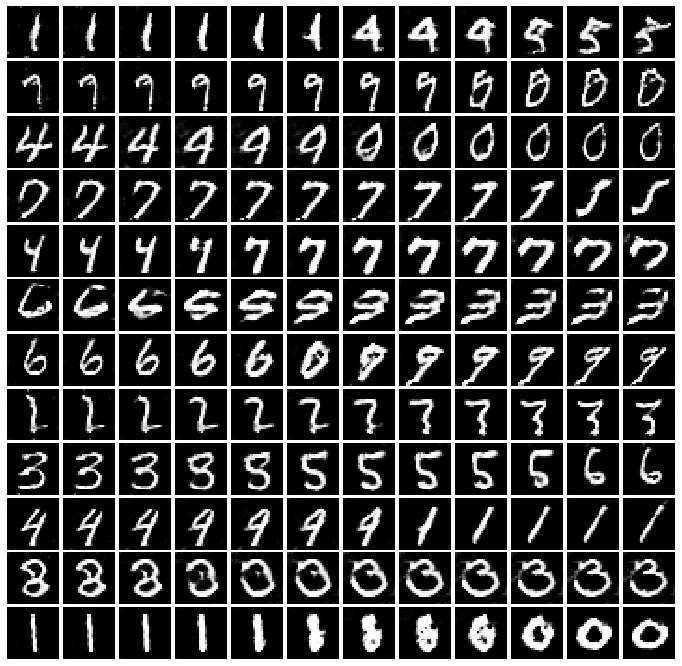

In [89]:
S = 12
z0 = sample_noise(S, NOISE_DIM, device=device)
z1 = sample_noise(S, NOISE_DIM, device=device)
w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, NOISE_DIM)

x = G_DC(z)
show_images(x.data.cpu())